added testing cell, added f1 cell

**1, Install core GPU stack**, Installs CUDA-12.1 PyTorch plus Transformers, bitsandbytes, PEFT and other NLP libraries (but not datasets yet).

In [1]:
# CUDA 12.1 Torch matching free T4 GPU
!pip install -q --upgrade --index-url https://download.pytorch.org/whl/cu121 \
    torch torchvision torchaudio

# NLP libs (leave out datasets for now)
!pip install -q transformers==4.41.0 bitsandbytes==0.42.0 peft==0.10.0 \
    accelerate sentencepiece pandas scikit-learn



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

**2, Purge conflicting packages**， Uninstalls Colab-bundled extras (fastai, spacy, bigframes, etc.) that would force NumPy 2.x and cause version clashes.

In [2]:
# Purge extras that conflict with NumPy 1.26
!pip uninstall -y fastai fastcore gcsfs fsspec spacy thinc triton bigframes-core bigframes -q


**3， Pin NumPy 1.26 + Datasets 2.19**， Installs NumPy 1.26 (Legacy API) and Datasets 2.19 with matching fsspec/gcsfs, eliminating the NumPy-2 “copy=False” issue.

In [3]:
#  📌  Compatible trio: NumPy-1.26 + datasets-2.19 + fsspec/gcsfs 2023.6
!pip install -q --no-deps numpy==1.26.4 datasets==2.19.0 \
                      fsspec==2023.6.0 gcsfs==2023.6.0




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.8 MB/s eta 0:00:00


In [4]:
!pip install -q --upgrade pyarrow==15.0.2 datasets==2.20.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 41.6 MB/s eta 0:00:00


**4, Restart runtime**

**5, 	Import libraries**， Brings in Torch, Pandas, HF Datasets, Transformers, PEFT for the rest of the notebook.

In [1]:
import torch, os, sys
print("Torch:", torch.__version__, "| CUDA available ➜", torch.cuda.is_available())
if torch.cuda.is_available():
    !nvidia-smi -L


Torch: 2.5.1+cu121 | CUDA available ➜ True
GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-b87e6adf-323a-2ccd-57b7-cff32574406d)


In [2]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)
from peft import LoraConfig, get_peft_model
import torch


**6，Load DeBERTa-v3-ABSA in 8-bit & inject LoRA**, Downloads the 3-class ABSA checkpoint in 8-bit; adds rank-16 LoRA adapters to attention & MLP layers.

In [3]:
# 5️⃣  Load DeBERTa-v3 base in fp32 (fits easily in 40 GB A100 VRAM)

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig

BASE_MODEL = "yangheng/deberta-v3-base-absa-v1.1"
NUM_LABELS = 3

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

import torch

base_model = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL,
    num_labels  = NUM_LABELS,
    torch_dtype = torch.float32,      # ✅ use the torch dtype object
    device_map  = {"": 0},
)

# LoRA (keep your rank / alpha)
lora_cfg = LoraConfig(
    r = 32,
    lora_alpha = 64,
    lora_dropout = 0.05,
    target_modules = ["query_proj","key_proj","value_proj","output_proj","dense"],
    task_type = "SEQ_CLS",
)

model = get_peft_model(base_model, lora_cfg)
model.to("cuda")                # moves LoRA + base to A100
model.print_trainable_parameters()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

trainable params: 5,359,875 || all params: 189,784,326 || trainable%: 2.8241926575116643


In [4]:
from peft import LoraConfig, get_peft_model

lora_cfg = LoraConfig(
    task_type      = "SEQ_CLS",
    r              = 32,
    lora_alpha     = 64,
    lora_dropout   = 0.05,
    target_modules = ["query_proj","key_proj","value_proj","out_proj","dense"],
)

model = get_peft_model(model, lora_cfg)
print("Trainable parameters (LoRA):",
      sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6, "M")


Trainable parameters (LoRA): 5.359875 M


**7,	Upload dataset CSV**

In [6]:
from google.colab import files
from IPython.display import display

#uploaded = files.upload()                 # choose your CSV
#CSV_PATH  = next(iter(uploaded))

import pandas as pd
df = pd.read_csv("sample_1000_labelled_firstpass_ready4colab.csv")                # expects: text, aspect, label
display(df.head())


,text,aspect,label
0,Seems nice. I ordered the wrong case thinking ...,customer service,Negative
1,"I love this product. It can hold a lap top, t...",customer service,Positive
2,"This is a good screen, but not quite as.... qu...",customer service,Neutral
3,bluetooth range is not good. also every time i...,customer service,Negative
4,Shipping time from China about 6 weeks. ORIGIN...,customer service,Neutral


In [7]:
# ▶︎ 1 — inspect current class counts
print(df["label"].value_counts())

# ▶︎ 2 — up-sample minority classes to ~equal size  ✱
from sklearn.utils import resample
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
df["label"] = df["label"].map(label_map)
neg = df[df.label == 0]                    # 513 rows
neu = df[df.label == 1]
pos = df[df.label == 2]

neu_up = resample(neu, replace=True, n_samples=500, random_state=42)
pos_up = resample(pos, replace=True, n_samples=500, random_state=42)

df_bal = pd.concat([neg, neu_up, pos_up]).sample(frac=1, random_state=42)

print("After up-sampling:\n", df_bal["label"].value_counts())


label
Negative    513
Positive    338
Neutral     149
Name: count, dtype: int64
After up-sampling:
 label
0    513
1    500
2    500
Name: count, dtype: int64


In [8]:
# ⬇️ put this just after you build the DataFrames
import torch

# frequency-inverse weights
freqs   = df["label"].value_counts().sort_index()       # (0,1,2)
weights = torch.tensor(1.0 / freqs, dtype=torch.float)  # [w0,w1,w2]
weights = weights / weights.sum() * len(weights)        # normalise




**8, Map labels & stratified split**, 	Converts “negative/neutral/positive” to 0/1/2 and creates 90 / 10 train-validation splits.

In [9]:
# 🔄 Convert sentiment strings ➜ integers, then stratified 90/10 split
#  60/20/20

from sklearn.model_selection import train_test_split
# First split: train (60%) and temp (40%)
train_df, temp_df = train_test_split(
    df_bal, test_size=0.4, stratify=df_bal["label"], random_state=31
)

# Second split: validation (20%) and test (20%) from temp
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=31
)

print("Train rows:", len(train_df), "| Val rows:", len(val_df))


Train rows: 907 | Val rows: 303


**9, Tokenise reviews with aspect**, Encodes each review with the aspect as text_pair, truncates to 256 tokens, builds a DatasetDict ready for PyTorch.

In [10]:
MAX_LEN = 256
def tok_fn(batch):
    return tokenizer(batch["text"], text_pair=batch["aspect"],
                     truncation=True, max_length=MAX_LEN)

ds = DatasetDict(
    train      = Dataset.from_pandas(train_df.reset_index(drop=True)),
    validation = Dataset.from_pandas(val_df.reset_index(drop=True)),
).map(tok_fn, batched=True)

ds = ds.remove_columns(["text","aspect"]).rename_column("label","labels")
ds.set_format("torch")
ds


Map:   0%|          | 0/907 [00:00<?, ? examples/s]

Map:   0%|          | 0/303 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 907
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 303
    })
})

**10,	Set training arguments & build Trainer**, Disables wandb, defines batch size/epochs/learning-rate, and constructs the Hugging-Face Trainer with dynamic-padding collator.

In [11]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import os
os.environ["WANDB_DISABLED"] = "true"          # disable wandb prompt
args = TrainingArguments(
    output_dir               = "deberta_absa_cls",
    per_device_train_batch_size = 16,   # bigger batch fits on A100
    per_device_eval_batch_size  = 16,
    num_train_epochs         = 64,
    learning_rate            = 5e-4,
    fp16                     = False,   # ← turn OFF mixed precision
    bf16                     = False,   # (leave both False for fp32)
    evaluation_strategy      = "epoch",
    save_strategy            = "epoch",
    logging_steps            = 50,
    report_to                = "none",
    load_best_model_at_end   = True,
    metric_for_best_model    = "macro_f1",
    greater_is_better        = True,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc  = accuracy_score(labels, preds)
    f1   = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": f1}


In [13]:
# 🔧 Custom trainer that overrides compute_loss
from transformers import Trainer
from torch.nn import CrossEntropyLoss
import torch

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_counts=None, **kwargs):
        super().__init__(*args, **kwargs)
        # save class-frequency counts so we can build weights once
        self.class_counts = (torch.tensor(class_counts)
                             if class_counts is not None else None)
        self._ce_weights = None            # will be initialised on first batch

    def compute_loss(self, model, inputs, return_outputs=False):
        labels  = inputs.pop("labels")                # LongTensor
        outputs = model(**inputs)
        logits  = outputs.logits                      # fp16/bf16 if enabled

        # build & cache class-imbalance weights on *first* call
        if self._ce_weights is None:
            if self.class_counts is None:
                raise RuntimeError("Need class_counts to build weights")
            w = 1.0 / self.class_counts.float()
            w = w / w.sum()                           # normalise
            self._ce_weights = w.to(logits.device, dtype=logits.dtype)

        loss_fct = CrossEntropyLoss(weight=self._ce_weights)
        loss     = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [14]:
# class counts seen in your CSV
cls_counts = train_df["label"].value_counts().sort_index().tolist()

trainer = WeightedLossTrainer(
    model            = model,
    args             = args,
    train_dataset    = ds["train"],
    eval_dataset     = ds["validation"],
    tokenizer        = tokenizer,
    data_collator    = DataCollatorWithPadding(tokenizer, return_tensors="pt"),
    compute_metrics  = compute_metrics,   # accuracy + macro-F1
    class_counts     = cls_counts,        # ← for loss re-weighting
)



**11,	Fine-tune the model**,Runs three epochs of LoRA training on the T4 GPU; prints epoch-level progress.

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.739500,0.589981,0.775578,0.774079
2,0.481800,0.348952,0.887789,0.888022
3,0.263700,0.409378,0.910891,0.910171
4,0.226500,0.388938,0.874587,0.875451
5,0.181100,0.465978,0.904290,0.903555
6,0.101500,1.035788,0.825083,0.819248
7,0.071100,1.133111,0.841584,0.835538
8,0.038200,0.431115,0.930693,0.930415
9,0.066800,0.545237,0.884488,0.882012
10,0.071100,0.792684,0.858086,0.855799


TrainOutput(global_step=3648, training_loss=0.036703099349172895, metrics={'train_runtime': 911.7093, 'train_samples_per_second': 63.669, 'train_steps_per_second': 4.001, 'total_flos': 8056386448623900.0, 'train_loss': 0.036703099349172895, 'epoch': 64.0})

**12,Evaluate & export adapter**, 	Computes accuracy / macro-F1 (with your compute_metrics), then saves the tiny LoRA adapter and tokenizer for later inference.

In [16]:
# 📊  Evaluation & saving
metrics = trainer.evaluate()
print("Validation metrics:", metrics)

# Save only the LoRA weights (few-MB folder)
adapter_dir = "deberta_lora_adapter"
model.save_pretrained(adapter_dir)
tokenizer.save_pretrained(adapter_dir)        # optional: saves vocab + config

print(f"LoRA adapter saved to  /content/{adapter_dir}")


Validation metrics: {'eval_loss': 0.43111538887023926, 'eval_accuracy': 0.9306930693069307, 'eval_macro_f1': 0.9304154722100622, 'eval_runtime': 1.6151, 'eval_samples_per_second': 187.609, 'eval_steps_per_second': 11.764, 'epoch': 64.0}
LoRA adapter saved to  /content/deberta_lora_adapter


Map:   0%|          | 0/303 [00:00<?, ? examples/s]

🔸 Test accuracy  : 0.9076
🔸 Test macro-F1 : 0.9074


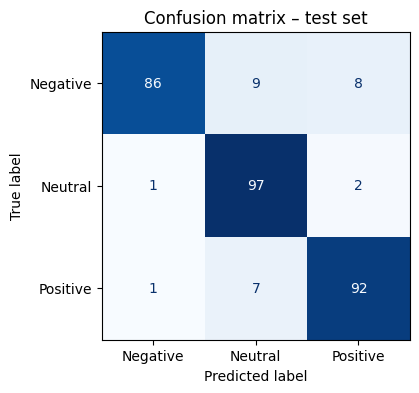

In [17]:
#  📊  Final evaluation on held-out TEST set
# ---------------------------------------------------
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# ⚙️  Build a tiny Dataset from the pandas test_df
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))
test_ds = test_ds.map(
    lambda batch: tokenizer(batch["text"],               # 👈  if you used aspect, pair it here
                            truncation=True,
                            max_length=256),
    batched=True)
test_ds = test_ds.remove_columns(["text"]).rename_column("label", "labels")
test_ds.set_format("torch")

# 🔍  Run the model
with torch.no_grad():
    preds, golds = [], []
    for batch in trainer.get_eval_dataloader(test_ds):
        batch = {k: v.to(trainer.model.device) for k, v in batch.items()}
        out   = trainer.model(**batch)
        preds.extend(out.logits.argmax(dim=-1).cpu().numpy())
        golds.extend(batch["labels"].cpu().numpy())

# 📈  Metrics
acc = accuracy_score(golds, preds)
f1  = f1_score(golds, preds, average="macro")

print(f"🔸 Test accuracy  : {acc:.4f}")
print(f"🔸 Test macro-F1 : {f1:.4f}")

# 🖼️  Confusion matrix
cm  = confusion_matrix(golds, preds, labels=[0,1,2])
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Neutral", "Positive"])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion matrix – test set")
plt.show()


In [18]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import pandas as pd

# golds and preds come from the previous cell --------------------------
report = classification_report(
    golds, preds,
    target_names=["Negative", "Neutral", "Positive"],
    digits=4, output_dict=True)

# Pretty table
display(pd.DataFrame(report).T.iloc[:3])   # first 3 rows are the classes

# If you only need the vectors:
per_class_f1  = f1_score(golds, preds, average=None)
per_class_prc = precision_score(golds, preds, average=None)
per_class_rec = recall_score(golds, preds, average=None)

print("F1  per class:", per_class_f1)
print("Prec per class:", per_class_prc)
print("Rec  per class:", per_class_rec)


,precision,recall,f1-score,support
Negative,0.977273,0.834951,0.900524,103.0
Neutral,0.858407,0.970000,0.910798,100.0
Positive,0.901961,0.920000,0.910891,100.0


F1  per class: [0.90052356 0.91079812 0.91089109]
Prec per class: [0.97727273 0.85840708 0.90196078]
Rec  per class: [0.83495146 0.97       0.92      ]


In [19]:
# Re‑use the pandas `test_df` already created in the notebook
X_test = test_df["text"].tolist()
y_test = test_df["label"].tolist()          # integers 0/1/2
aspects  = test_df["aspect"].tolist()       # for per‑aspect cut


In [20]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [21]:
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import numpy as np

sid = SentimentIntensityAnalyzer()

def vader_pred(text):
    score = sid.polarity_scores(text)["compound"]
    return 2 if score > 0.05 else 0 if score < -0.05 else 1   # 2=Pos,1=Neu,0=Neg

def tb_pred(text):
    score = TextBlob(text).sentiment.polarity
    return 2 if score >  0.1 else 0 if score < -0.1 else 1


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

svm_clf = make_pipeline(
        TfidfVectorizer(max_features=30_000, ngram_range=(1,2)),
        LinearSVC(C=1.0)
)
svm_clf.fit(train_df["text"], train_df["label"])


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=30000, ngram_range=(1, 2))),
                ('linearsvc', LinearSVC())])

In [23]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd, collections

def eval_preds(name, preds):
    acc = accuracy_score(y_test, preds)
    f1  = f1_score(y_test, preds, average="macro")
    return acc, f1

results = collections.OrderedDict()

# Transformer scores already printed during notebook run ↓
results["DeBERTa‑LoRA"] = (acc, f1)      # from test cell :contentReference[oaicite:0]{index=0}

# VADER
results["VADER"]        = eval_preds("VADER", list(map(vader_pred, X_test)))
# TextBlob
results["TextBlob"]     = eval_preds("TextBlob", list(map(tb_pred, X_test)))
# TF‑IDF + SVM
results["TF‑IDF + SVM"] = eval_preds("SVM", svm_clf.predict(X_test))

display(pd.DataFrame(results, index=["Accuracy","Macro‑F1"]).T)


,Accuracy,Macro‑F1
DeBERTa‑LoRA,0.907591,0.907404
VADER,0.425743,0.343089
TextBlob,0.455446,0.407420
TF‑IDF + SVM,0.884488,0.884602


In [24]:
def per_aspect_scores(model_name, predict_fn):
    rows = []
    for asp in set(aspects):
        mask = [a == asp for a in aspects]
        y_a  = np.array(y_test)[mask]
        # Filter predictions based on the aspect mask
        p_a  = np.array(predict_fn(np.array(X_test)[mask])) if model_name != "DeBERTa‑LoRA" else np.array(preds)[mask]
        rows.append(
            dict(Model=model_name, Aspect=asp,
                 Acc = accuracy_score(y_a, p_a),
                 F1  = f1_score(y_a, p_a, average="macro"))
        )
    return rows

table = []
table += per_aspect_scores("DeBERTa‑LoRA", lambda x: preds)    # `preds` already computed
table += per_aspect_scores("TF‑IDF + SVM", svm_clf.predict)
table += per_aspect_scores("VADER", np.vectorize(vader_pred))
table += per_aspect_scores("TextBlob", np.vectorize(tb_pred))
display(pd.DataFrame(table))

,Model,Aspect,Acc,F1
0,DeBERTa‑LoRA,product quality,0.930380,0.930627
1,DeBERTa‑LoRA,customer service,0.882759,0.882617
2,TF‑IDF + SVM,product quality,0.886076,0.884837
3,TF‑IDF + SVM,customer service,0.882759,0.884103
4,VADER,product quality,0.468354,0.378759
5,VADER,customer service,0.379310,0.301819
6,TextBlob,product quality,0.512658,0.474259
7,TextBlob,customer service,0.393103,0.333141
